In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import h5py

import sys
sys.path.append('../../../src')
from utils import smooth_curve
from viz import show_images
from PlumeDataset import plume_dataset
from AutoAlign import align_plumes
from Velocity import VelocityCalculator
from PlumeMetrics import PlumeMetrics
from HorizontalLineProfileAnalyzer import HorizontalLineProfileAnalyzer
from AutoAlign import visualize_corners
from analyze_function import analyze_function

## laser fluence dependent

In [2]:
df_condition = pd.read_excel('../../../datasets/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[22,24,28,31], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('2 to 1.73', (2+1.73)/2, inplace=True)
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)

# print('Pressure (mTorr):', df_condition['Pressure (mTorr)'].unique())
# print('Temperature (C):', df_condition['Temperature (C)'].unique())
# print('Fluence (J/cm2):', df_condition['Fluence (J/cm2)'].unique())
# print('Repetation rate (Hz):', df_condition['Repetation rate (Hz)'].unique())
df_condition

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
22,YG051,75.0,700,2.05,5.0
24,YG053,75.0,700,1.60,5.0
28,YG057,75.0,700,1.23,5.0
31,YG060,75.0,700,0.80,5.0


In [3]:
df_condition['Growth'].unique()

array(['YG051', 'YG053', 'YG057', 'YG060'], dtype=object)

In [4]:
df_plume_all = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../../datasets/SRO_plume_metrics/{key}*.csv')[0]
    df = pd.read_csv(file)
    df_plume_all.append(df)
df_plume_all = pd.concat(df_plume_all)
df_condition['Growth'].unique()

array(['YG051', 'YG053', 'YG057', 'YG060'], dtype=object)

In [5]:
df_merged = pd.merge(df_condition, df_plume_all, on='Growth')
df_merged

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),plume_index,time_index,Distance,Velocity,Area,Threshold
0,YG051,75.0,700,2.05,5.0,0,0,0,0.0,0.0,5
1,YG051,75.0,700,2.05,5.0,0,1,0,0.0,0.0,5
2,YG051,75.0,700,2.05,5.0,0,2,363,726000000.0,99971.0,5
3,YG051,75.0,700,2.05,5.0,0,3,363,0.0,24220.0,5
4,YG051,75.0,700,2.05,5.0,0,4,363,0.0,34138.0,5
...,...,...,...,...,...,...,...,...,...,...,...
382459,YG060,75.0,700,0.80,5.0,305,123,147,0.0,0.0,flexible
382460,YG060,75.0,700,0.80,5.0,305,124,147,0.0,0.0,flexible
382461,YG060,75.0,700,0.80,5.0,305,125,147,0.0,0.0,flexible
382462,YG060,75.0,700,0.80,5.0,305,126,147,0.0,0.0,flexible


In [6]:
for key in df_plume_all['Growth'].unique():
    print(key)
    print(df_plume_all[df_plume_all['Growth']==key]['Threshold'].unique())

YG051
['5' '200' 'flexible']
YG053
['5' '200' 'flexible']
YG057
['5' '200' 'flexible']
YG060
['5' '200' 'flexible']


In [8]:
label = 'Fluence (J/cm2)'

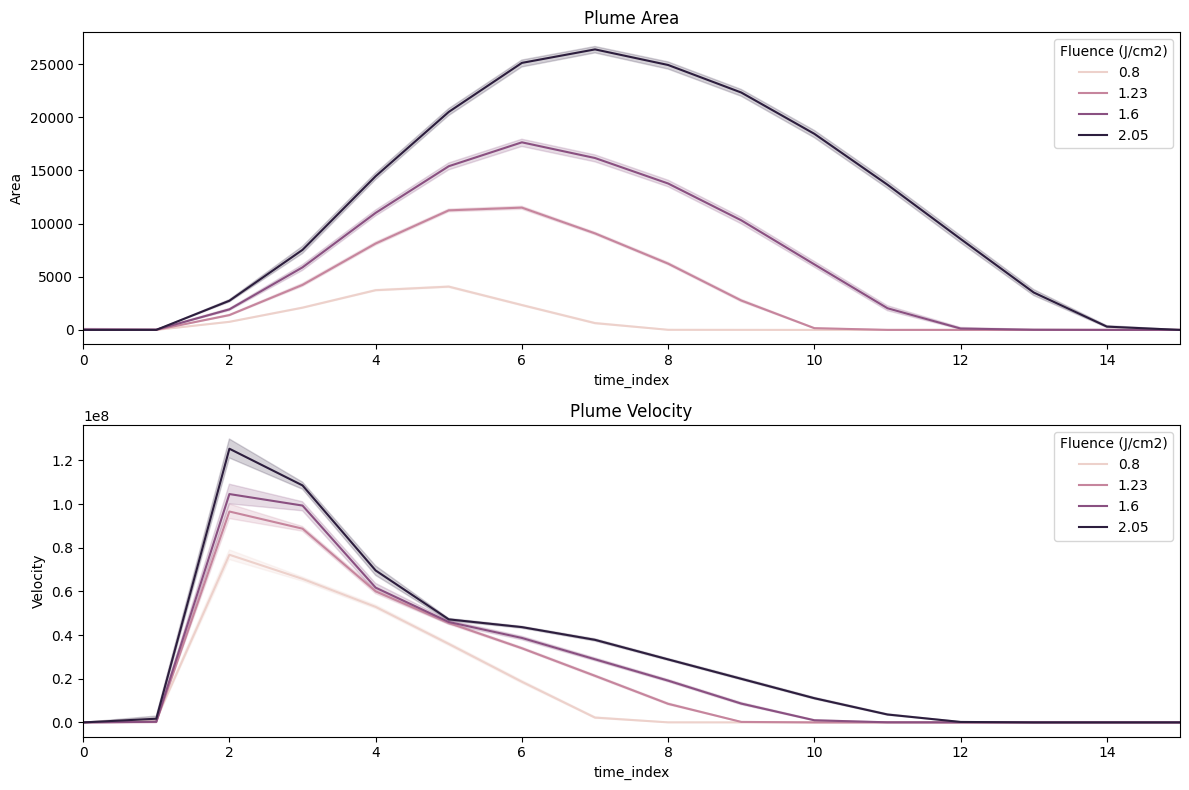

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Area", hue=label, data=df_merged[df_merged['Threshold']=='200'], ax=axes[0])
axes[0].set_title('Plume Area')
axes[0].set_xlim(0, 15)
lineplot = sns.lineplot(x="time_index", y="Velocity", hue=label, data=df_merged[df_merged['Threshold']=='200'], ax=axes[1])
axes[1].set_title('Plume Velocity')
axes[1].set_xlim(0, 15)
plt.tight_layout()
plt.show()

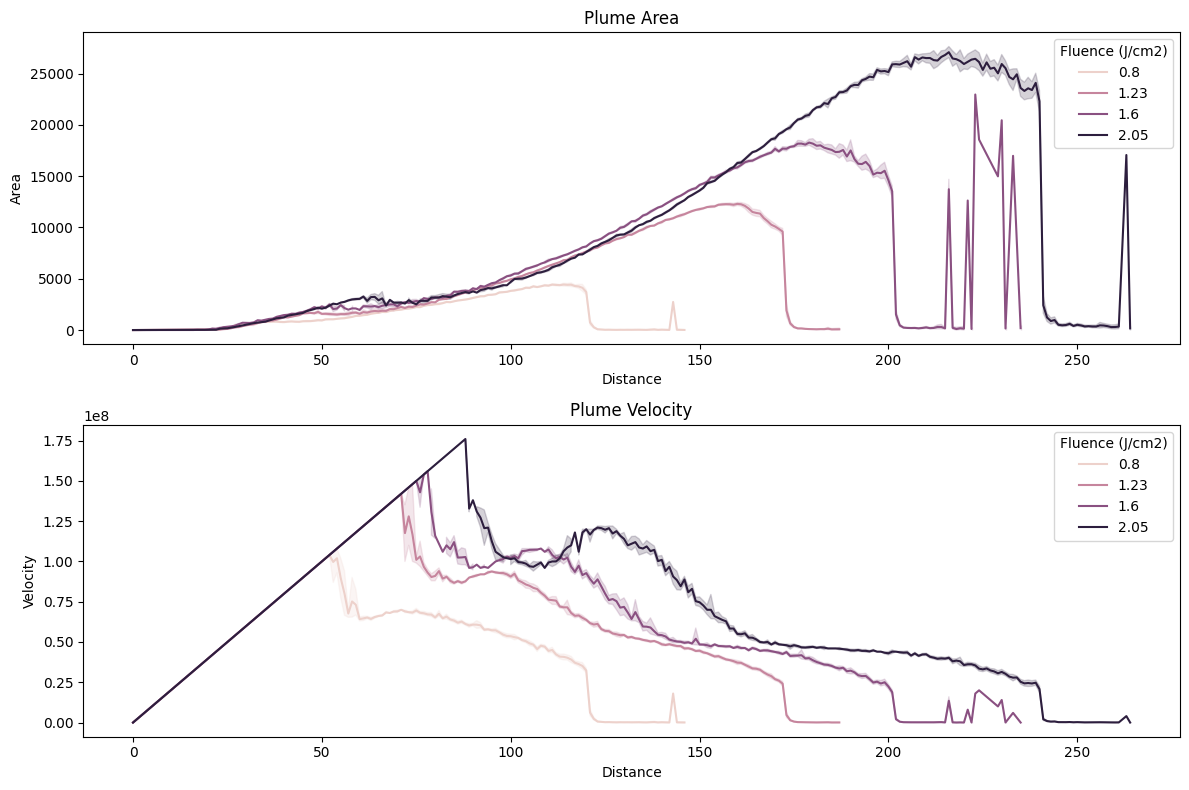

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="Distance", y="Area", hue=label, data=df_merged[df_merged['Threshold']=='200'], ax=axes[0])
axes[0].set_title('Plume Area')
lineplot = sns.lineplot(x="Distance", y="Velocity", hue=label, data=df_merged[df_merged['Threshold']=='200'], ax=axes[1])
axes[1].set_title('Plume Velocity')
plt.tight_layout()
plt.show()

## pressure dependent plume dynamics

In [2]:
df = pd.read_excel('../../../datasets/Sample log.xlsx', sheet_name='SRO')
df_condition = df.loc[[30,24,27,29,32], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('2 to 1.73', (2+1.73)/2, inplace=True)
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)

# print('Pressure (mTorr):', df_condition['Pressure (mTorr)'].unique())
# print('Temperature (C):', df_condition['Temperature (C)'].unique())
# print('Fluence (J/cm2):', df_condition['Fluence (J/cm2)'].unique())
# print('Repetation rate (Hz):', df_condition['Repetation rate (Hz)'].unique())
df_condition

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
30,YG059,50.0,700,1.6,5.0
24,YG053,75.0,700,1.6,5.0
27,YG056,100.0,700,1.6,5.0
29,YG058,125.0,700,1.6,5.0
32,YG061,150.0,700,1.6,5.0


In [3]:
df_condition['Growth'].unique()

array(['YG059', 'YG053', 'YG056', 'YG058', 'YG061'], dtype=object)

In [4]:
df_plume_all = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../../datasets/SRO_plume_metrics/{key}*.csv')[0]
    df = pd.read_csv(file)
    df_plume_all.append(df)
df_plume_all = pd.concat(df_plume_all)
df_condition['Growth'].unique()

array(['YG059', 'YG053', 'YG056', 'YG058', 'YG061'], dtype=object)

In [5]:
df_merged = pd.merge(df_condition, df_plume_all, on='Growth')
df_merged

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),plume_index,time_index,Distance,Velocity,Area,Threshold
0,YG059,50.0,700,1.6,5.0,0,0,0,0.0,0.0,5
1,YG059,50.0,700,1.6,5.0,0,1,0,0.0,0.0,5
2,YG059,50.0,700,1.6,5.0,0,2,197,394000000.0,22401.0,5
3,YG059,50.0,700,1.6,5.0,0,3,197,0.0,17179.0,5
4,YG059,50.0,700,1.6,5.0,0,4,219,44000000.0,32615.0,5
...,...,...,...,...,...,...,...,...,...,...,...
577915,YG061,150.0,700,1.6,5.0,376,123,15,0.0,0.0,flexible
577916,YG061,150.0,700,1.6,5.0,376,124,15,0.0,0.0,flexible
577917,YG061,150.0,700,1.6,5.0,376,125,15,0.0,0.0,flexible
577918,YG061,150.0,700,1.6,5.0,376,126,15,0.0,0.0,flexible


In [9]:
for key in df_plume_all['Growth'].unique():
    print(key, df_plume_all[df_plume_all['Growth']==key]['Threshold'].unique())

YG059 ['5' '200' 'flexible']
YG053 ['5' '200' 'flexible']
YG056 ['5' '200' 'flexible']
YG058 ['5' '200' 'flexible']
YG061 ['5' '200' 'flexible']


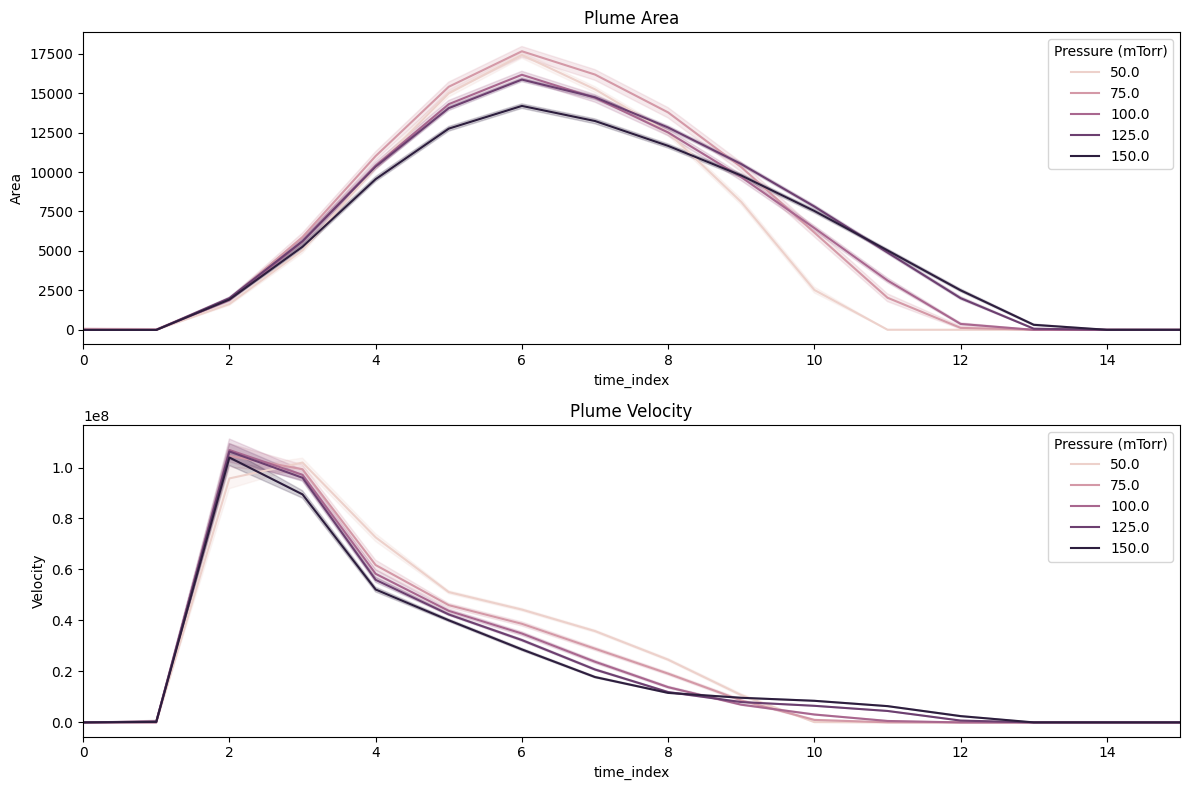

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Area", hue="Pressure (mTorr)", data=df_merged[df_merged['Threshold']=='200'], ax=axes[0])
axes[0].set_title('Plume Area')
axes[0].set_xlim(0, 15)
lineplot = sns.lineplot(x="time_index", y="Velocity", hue="Pressure (mTorr)", data=df_merged[df_merged['Threshold']=='200'], ax=axes[1])
axes[1].set_title('Plume Velocity')
axes[1].set_xlim(0, 15)
plt.tight_layout()
plt.show()

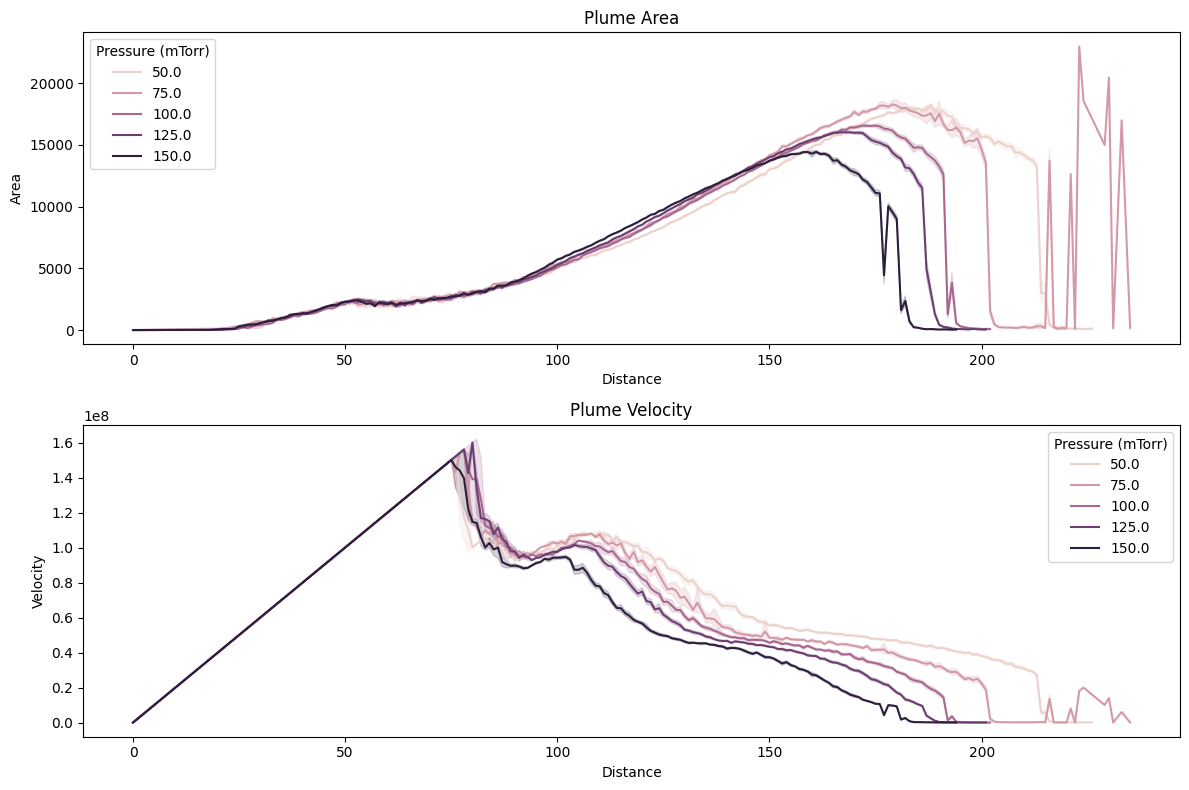

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="Distance", y="Area", hue="Pressure (mTorr)", data=df_merged[df_merged['Threshold']=='200'], ax=axes[0])
axes[0].set_title('Plume Area')
lineplot = sns.lineplot(x="Distance", y="Velocity", hue="Pressure (mTorr)", data=df_merged[df_merged['Threshold']=='200'], ax=axes[1])
axes[1].set_title('Plume Velocity')
plt.tight_layout()
plt.show()

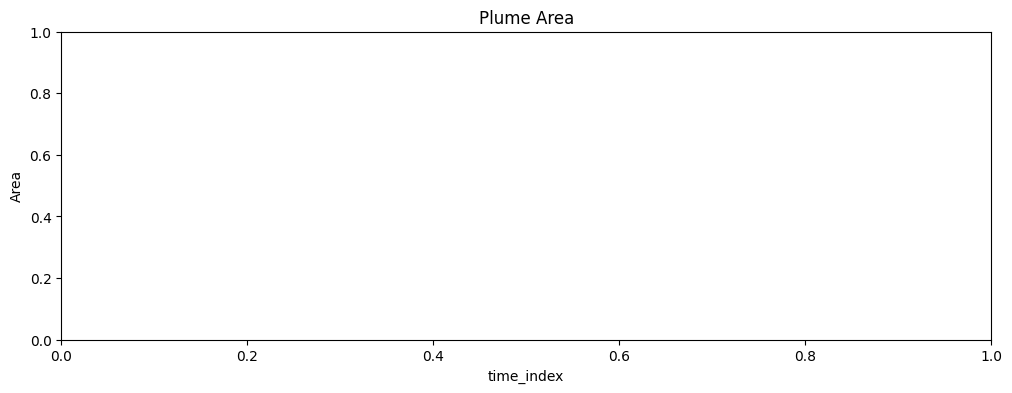

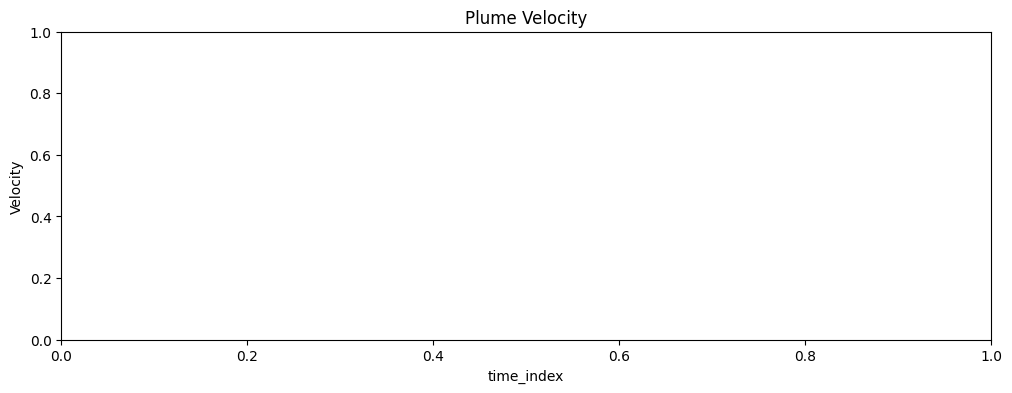

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_plume_all[df_plume_all['Threshold']==5])
plt.title('Plume Area')
# plt.xlim(0, 32)
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue="Growth", data=df_plume_all[df_plume_all['Threshold']==5])
plt.title('Plume Velocity')
plt.show()

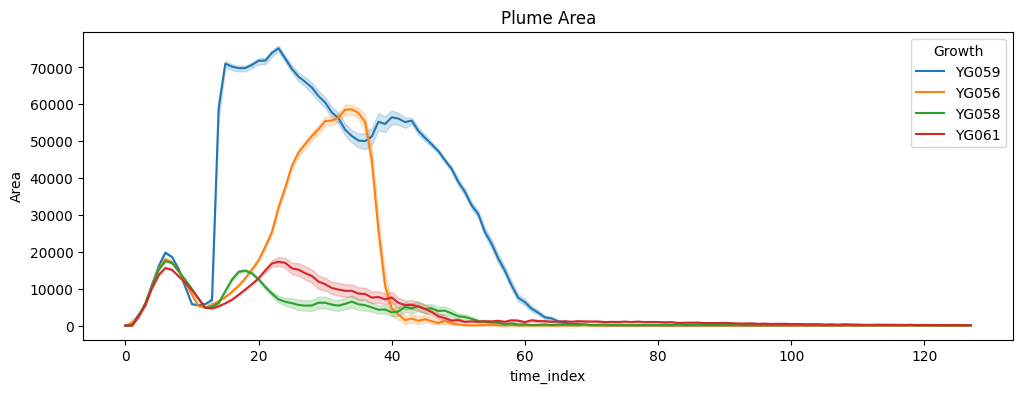

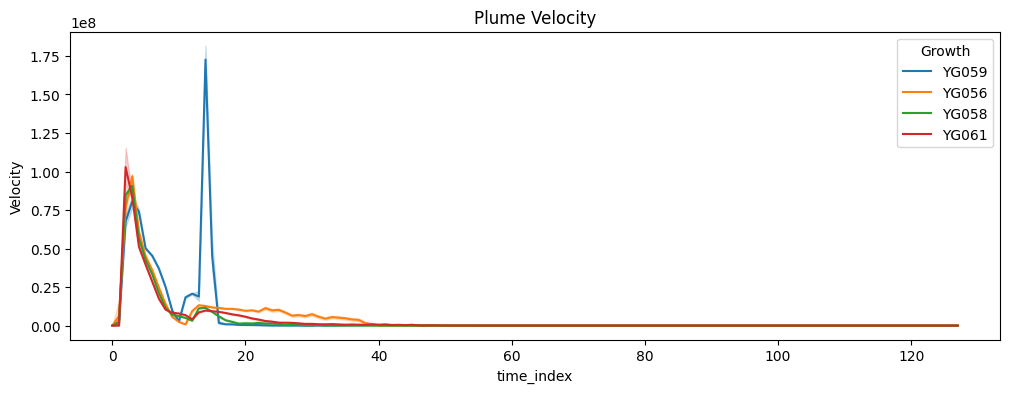

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_plume_all[df_plume_all['Threshold']=='flexible'])
plt.title('Plume Area')
# plt.xlim(0, 32)
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue="Growth", data=df_plume_all[df_plume_all['Threshold']=='flexible'])
plt.title('Plume Velocity')
plt.show()

In [6]:
df_all = []
for file in glob.glob('../../../datasets/SRO_plume_metrics/*.csv'):
    df = pd.read_csv(file)
    df_all.append(df)
df_all = pd.concat(df_all)
df_all

,plume_index,time_index,Distance,Velocity,Area,Growth
0,0,0,30,0.0,0.0,YG045
1,0,1,30,0.0,0.0,YG045
2,0,2,73,86000000.0,1742.0,YG045
3,0,3,119,92000000.0,6386.0,YG045
4,0,4,149,60000000.0,11184.0,YG045
...,...,...,...,...,...,...
39163,305,123,147,0.0,0.0,YG060
39164,305,124,147,0.0,0.0,YG060
39165,305,125,147,0.0,0.0,YG060
39166,305,126,147,0.0,0.0,YG060


In [ ]:
conditions = ['YG045', 'YG046', 'YG047', 'YG048', 'YG049', 'YG050', 'YG051', 'YG053'] 
df_plot = df_all[df_all['Growth'].isin(conditions)]

### plot

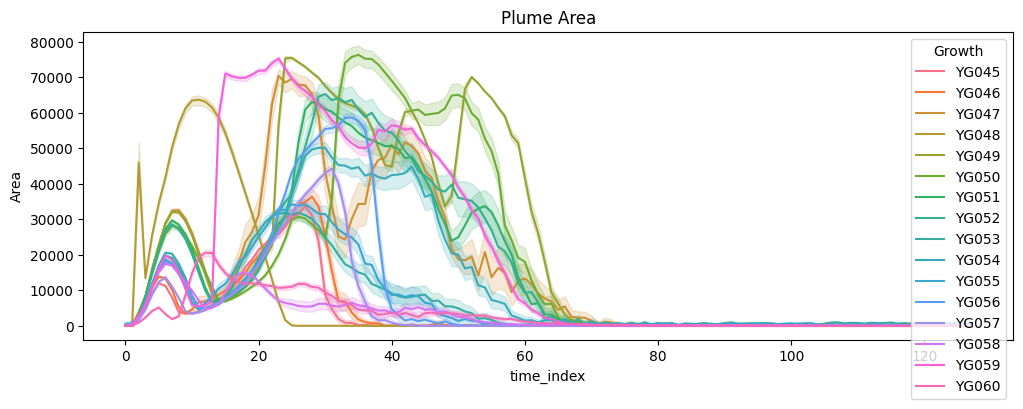

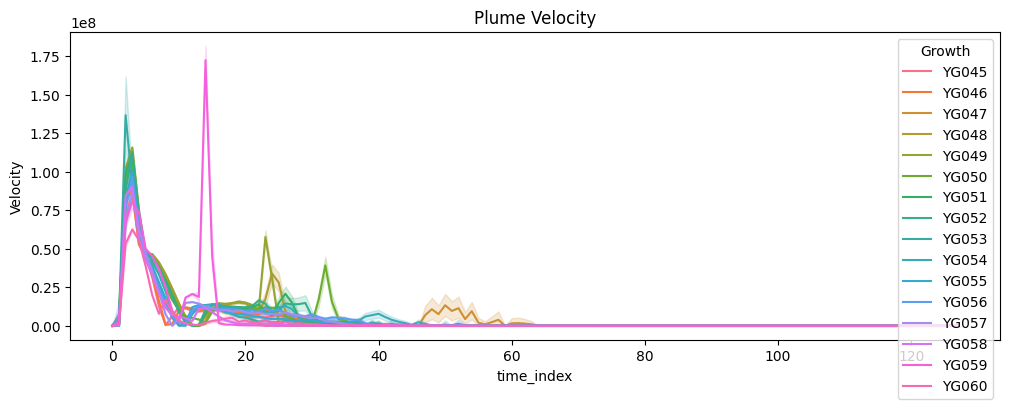

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_all)
plt.title('Plume Area')
# plt.xlim(0, 32)
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue="Growth", data=df_all)
plt.title('Plume Velocity')
plt.show()

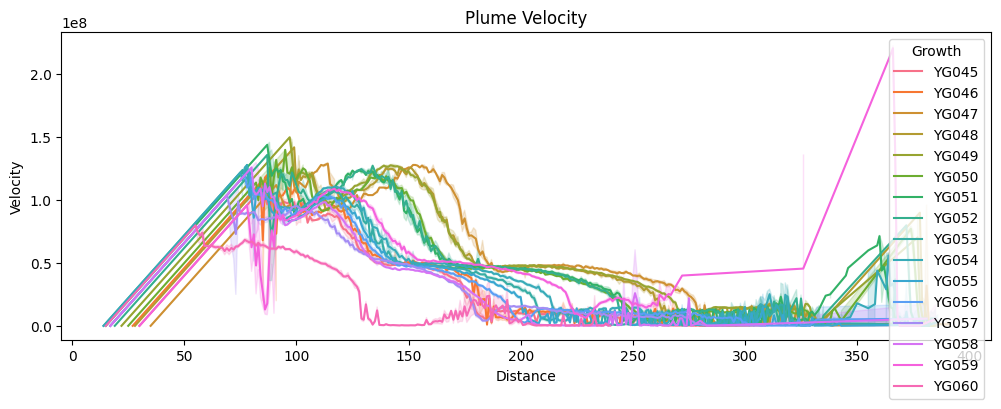

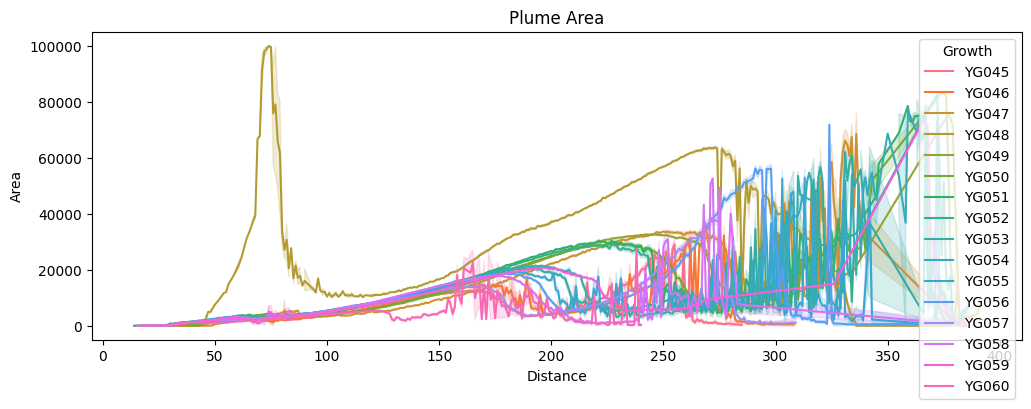

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="Distance", y="Velocity", hue="Growth", data=df_all)
plt.title('Plume Velocity')
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="Distance", y="Area", hue="Growth", data=df_all)
plt.title('Plume Area')
plt.show()